# Supervised Learning



# Base setup


In [1]:
% matplotlib inline

import jpholiday
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as itt
from sklearn.linear_model import *
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import * 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_percentage_error(y_true, y_pred):
    return np.mean(( (y_true - y_pred) / y_true)**2) * 100

import warnings
warnings.simplefilter('ignore')

pd.options.display.float_format = '{:20,.2f}'.format

## Getting data

In [2]:
base_df = pd.read_csv("../data/clean_proto_traffic.csv",parse_dates=True,  index_col="timestamp")

# Concept


## Adding Time Features


In [3]:
def add_holiday(frame, year):
    frame.loc[f"{year}-01-01":f"{year}-01-10", "is_newyear"] = 1
    frame.loc[f"{year}-12-28":f"{year}-12-31", "is_newyear"] = 1

    for date, holiday_name in jpholiday.year_holidays(year):
        if not str(date) in frame.index:
            continue
        #print(holiday_name)
        frame.loc[str(date), "is_holiday"] = 1
    return frame


def add_workhour(df, begin=8, end=18):
    work_df = (df["hour"].between(begin, end)) & (df["is_weekend"] == 0) & (df["is_holiday"] == 0)
    df["working_hour"] = work_df.values * 1
    return df


def add_features(series, lag_range=None, target_encoding=False):
    # copy of the initial dataset
    data = pd.DataFrame(series)
    data.columns = ["y"]

    data["y"] = data["y"].astype(np.float64)
    data["date"] =  data.index.date.astype(str)
    data["date"] = data.date.str.replace("-","").astype(int)
    
    
    
    
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1

    data["is_newyear"] = 0
    data["is_holiday"] = 0
    for year in data.index.year.unique():
        data = add_holiday(data, year)

    data = add_workhour(data)
    return data.dropna()

test_size = 0.2

data = add_features(base_df,target_encoding=True)




data.sample(n=10)

,y,date,hour,weekday,is_weekend,is_newyear,is_holiday,working_hour
timestamp,,,,,,,,
2018-03-28 05:10:00,"23,498,067,072.00",20180328,5,2,0,0,0,0
2017-09-29 21:50:00,"61,506,599,060.00",20170929,21,4,0,0,0,0
2015-03-22 21:20:00,"15,798,577,622.00",20150322,21,6,1,0,0,0
2015-02-18 23:45:30,"25,930,471,412.00",20150218,23,2,0,0,0,0
2013-06-13 08:54:44,"4,690,255,120.00",20130613,8,3,0,0,0,1
2016-09-22 07:20:00,"22,895,556,206.00",20160922,7,3,0,0,1,0
2016-02-14 01:40:00,"24,371,075,308.00",20160214,1,6,1,0,0,0
2016-04-01 05:30:00,"7,474,402,242.00",20160401,5,4,0,0,0,0
2016-08-11 02:40:00,"15,329,746,752.00",20160811,2,3,0,0,1,0


## Encoding the new features

encoding the features helps making the model learn more easily.
We replace the  intervalue representing days, weekend, etc.  by the average of the traffic
of each value

by example for weekday=1 becomes the average traffic of all datapoints with a 1
and if for weekday=0 become sthe average traffic of all datapoints with a 0 

In [4]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def encode_specified_field(data, test_size=0.3):
    # calculate averages on train set only
    test_index = int(len(data.dropna()) * (1 - test_size))
    data = encode_field(data, "weekday", "weekday_average", test_index)
    data = encode_field(data, "hour", "hour_average", test_index)
    data = encode_field(data, "working_hour", "workhour_average", test_index)
    data = encode_field(data, "is_weekend", "weekend_average", test_index)
    data = encode_field(data, "is_holiday", "holiday_average", test_index)
    data = encode_field(data, "is_newyear", "newyear_average", test_index)
    return data.dropna()


def encode_field(data, field, dst_field, test_index):
    data[dst_field] = list(map(
        code_mean(data[:test_index], field, "y").get, data[field]))
    data.drop([field], axis=1, inplace=True)
    return data




data_enc = encode_specified_field(data,test_size=test_size)

data_enc.sample(n=10)

,y,date,weekday_average,hour_average,workhour_average,weekend_average,holiday_average,newyear_average
timestamp,,,,,,,,
2016-06-10 11:30:00,"11,802,015,161.00",20160610,"22,310,846,670.82","16,219,088,321.89","15,993,759,585.77","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40"
2016-09-11 13:40:00,"9,372,405,959.00",20160911,"17,308,707,065.63","12,561,761,319.11","23,152,141,372.62","18,330,011,430.02","21,085,190,338.72","21,054,202,611.40"
2014-09-08 07:50:00,"14,307,845,234.00",20140908,"19,604,314,906.53","21,475,523,270.77","23,152,141,372.62","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40"
2015-01-19 10:10:00,"18,096,876,937.00",20150119,"19,604,314,906.53","18,210,361,016.95","15,993,759,585.77","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40"
2017-07-09 03:50:00,"21,434,361,646.00",20170709,"17,308,707,065.63","23,495,603,206.68","23,152,141,372.62","18,330,011,430.02","21,085,190,338.72","21,054,202,611.40"
2018-07-21 10:30:00,"18,530,699,318.00",20180721,"19,351,254,645.78","18,210,361,016.95","23,152,141,372.62","18,330,011,430.02","21,085,190,338.72","21,054,202,611.40"
2017-11-04 07:00:00,"27,248,094,587.00",20171104,"19,351,254,645.78","21,475,523,270.77","23,152,141,372.62","18,330,011,430.02","21,085,190,338.72","21,054,202,611.40"
2015-05-09 12:10:00,"11,737,273,798.00",20150509,"19,351,254,645.78","14,082,815,740.55","23,152,141,372.62","18,330,011,430.02","21,085,190,338.72","21,054,202,611.40"
2016-04-27 10:00:00,"12,533,235,235.00",20160427,"22,904,218,746.94","18,210,361,016.95","15,993,759,585.77","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40"


## Shifting the data

we offset the data traffic, so we can predict the traffic of a point, based on passed 
observation

with a minimum lag of 1 week, we can forecast a datapoint based on last week observations


In [5]:
data_offset = data_enc.copy()


lag_week = list(range (1008,1008*7 + 1,1008))
lag_day = list(range(144+1008,(144*6) + 1008,144))
lag_hour = list(range(144+1008,288+1008,6))
lag_min = list(range(144+1008,144+1008+18,1))
print("week_lag,",lag_week)
print("day_lag,",lag_day)
print("hour_lag,",lag_hour)
print("min_lag,",lag_min)

for i in itt.chain(lag_hour,lag_day,lag_week,lag_min):
    week= i // (1008)
    day=  (i % 1008) // 144
    hour = (i % 144) // 6
    mins = (i % 6) * 10 
    data_offset["lag_{}w{}d{}h{}m".format(week,day,hour,mins)] = data_enc.y.shift(i)
data_offset = data_offset.dropna()




data_offset.sample(5)

week_lag, [1008, 2016, 3024, 4032, 5040, 6048, 7056]
day_lag, [1152, 1296, 1440, 1584, 1728]
hour_lag, [1152, 1158, 1164, 1170, 1176, 1182, 1188, 1194, 1200, 1206, 1212, 1218, 1224, 1230, 1236, 1242, 1248, 1254, 1260, 1266, 1272, 1278, 1284, 1290]
min_lag, [1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169]


,y,date,weekday_average,hour_average,workhour_average,weekend_average,holiday_average,newyear_average,lag_1w1d0h0m,lag_1w1d1h0m,...,lag_1w1d1h10m,lag_1w1d1h20m,lag_1w1d1h30m,lag_1w1d1h40m,lag_1w1d1h50m,lag_1w1d2h10m,lag_1w1d2h20m,lag_1w1d2h30m,lag_1w1d2h40m,lag_1w1d2h50m
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-19 21:30:00,"44,537,192,479.00",20160119,"22,507,648,509.12","26,848,934,686.10","23,152,141,372.62","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40","25,422,760,526.00","20,499,546,405.00",...,"28,611,202,940.00","23,482,360,617.00","22,117,196,486.00","25,068,631,954.00","20,866,080,165.00","26,212,501,327.00","22,600,061,769.00","19,500,809,213.00","20,025,231,754.00","22,473,294,624.00"
2017-03-06 02:10:00,"31,939,880,747.00",20170306,"19,604,314,906.53","26,140,130,330.86","23,152,141,372.62","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40","30,302,798,924.00","27,824,429,649.00",...,"30,692,090,165.00","26,528,469,782.00","28,870,513,633.00","36,346,829,966.00","31,722,739,498.00","31,365,549,266.00","32,233,594,661.00","32,021,159,550.00","37,293,088,995.00","41,422,235,842.00"
2013-07-16 13:44:46,"3,066,603,724.00",20130716,"22,507,648,509.12","12,561,761,319.11","15,993,759,585.77","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40","5,016,781,762.00","5,392,350,862.00",...,"4,663,904,503.00","5,073,087,253.00","5,639,314,302.00","5,981,579,462.00","6,310,238,846.00","6,995,527,150.00","6,336,844,363.00","6,921,494,911.00","7,870,033,676.00","6,977,260,554.00"
2014-09-11 15:30:00,"10,321,862,094.00",20140911,"22,569,954,403.98","11,599,157,382.51","15,993,759,585.77","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40","9,835,147,852.00","10,146,906,412.00",...,"11,885,794,595.00","11,261,124,493.00","12,070,778,005.00","10,452,184,269.00","11,985,448,035.00","10,643,277,308.00","11,653,915,263.00","16,248,707,065.00","15,781,223,314.00","8,455,624,379.00"
2016-02-18 01:20:00,"34,628,629,568.00",20160218,"22,569,954,403.98","27,615,205,818.96","23,152,141,372.62","21,979,093,398.20","21,085,190,338.72","21,054,202,611.40","37,818,685,726.00","37,776,260,205.00",...,"38,357,373,227.00","35,786,276,737.00","37,587,557,189.00","35,478,720,614.00","38,596,979,274.00","35,324,706,732.00","39,799,554,266.00","41,398,482,151.00","36,528,239,060.00","37,790,995,786.00"


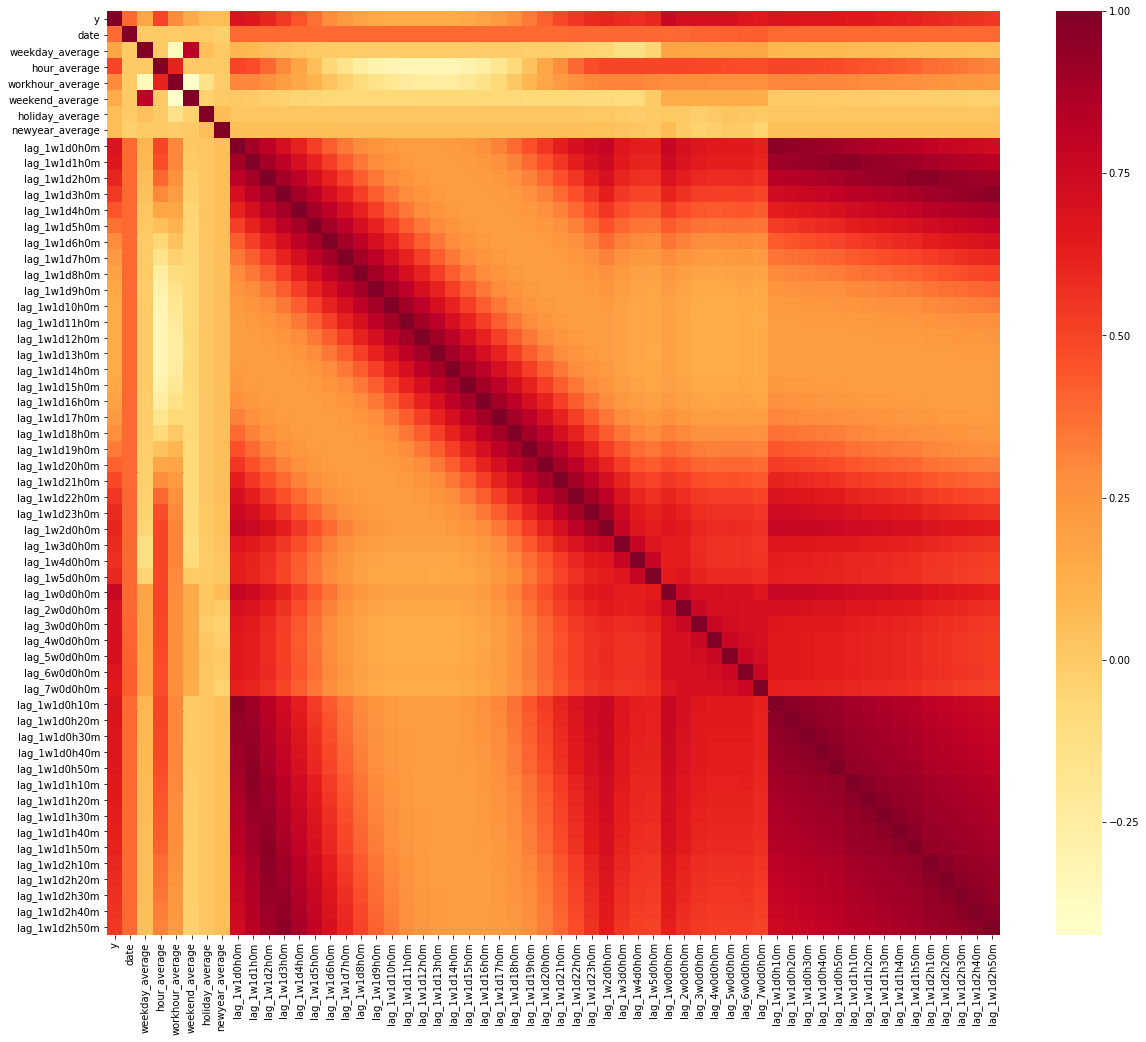

In [6]:
#we now can see how features relate to each others
plt.figure(figsize=(20,17))
sns.heatmap(data_offset.corr(),cmap='YlOrRd');

## data splitting

to do a valid training, the data should be splitted this way :

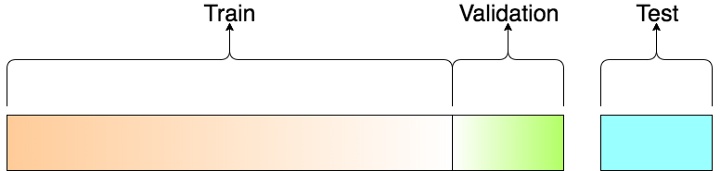

the training and validation dataset can be splitted in different way for better optimisation
(Cross validation, Grid Search, etc. ) 

In [7]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test


def split_data(data):
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    return X, y

X,y = split_data(data_offset)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

# we scale the data for the training
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Xtrain:", len(X_train),"| Xtest", len(X_test))
print("ytrain:", len(y_train),"| ytest", len(y_test))

Xtrain: 228166 | Xtest 57042
ytrain: 228166 | ytest 57042


# Modeling

In [13]:
def plotPredictionResult(prediction,y,title):
    with plt.style.context('seaborn-white'):   
        plt.figure(figsize=(15, 3))
        plt.plot(y.values, label="actual", linewidth=2.0)
        plt.plot(prediction, label="prediction", linewidth=2.0)
        plt.title(title)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True);

def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 3))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    
def showModelStats(model):
    pred_train,pred_test = model.predict(X_train_scaled),model.predict(X_test_scaled)

    def print_error(pred,real,name):
        print(f"{name}-r2:",r2_score(pred,real)* 100)
        print(f"{name}-MAPE:",100 - mean_absolute_percentage_error(pred,real),"%")
        print(f"{name}-MSPE:",100 - mean_squared_percentage_error(pred,real),"%")
        print("="*10)
    
    
    print_error(pred_train,y_train,"Train")
    plotPredictionResult(pred_train,y_train,title="Train Result")
    
    print_error(pred_test,y_test,"Test")
    plotPredictionResult(pred_test,y_test,title="Test Result")
    
    
    begin,end = -1008*8,-1
    zoom_pred,zoom_test = pred_test[begin:end],y_test[begin:end]
    print_error(zoom_pred,zoom_test,"Test")
    plotPredictionResult(zoom_pred,zoom_test,title="Zoomed Result")
    plotCoefficients(model)


# Linear Regression

A linear regression follow this equation

\begin{equation}
{y}_w(\vec{x}) = {w}_0 + {w}_1 x_1 + {w}_2 x_2 + ... +  {w}_i x_i
\end{equation}

Optmizing the parameter mea}ns finding the best w's for this function, each W are a parameter (lag,hour,etc) and y is 
the traffic value

we also try different variant (ridge,lasso) to see how good they perform

Train-r2: 52.07689403908833
Train-MAPE: 74.83114959892528 %
Train-MSPE: -9.633100902133407 %
Test-r2: 41.00692959706376
Test-MAPE: 77.95794339053256 %
Test-MSPE: 90.4561552887624 %
Test-r2: 63.83015551785276
Test-MAPE: 79.7615638162967 %
Test-MSPE: 93.77976469004254 %
Wall time: 939 ms


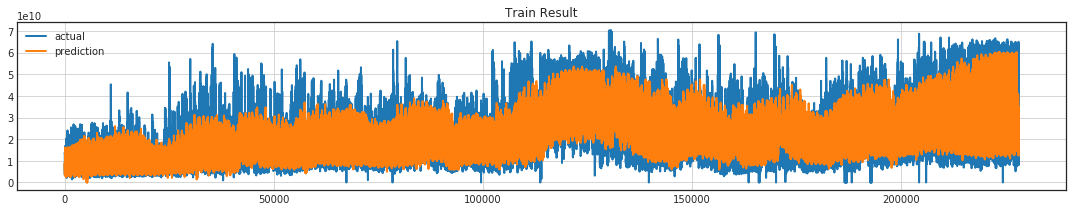

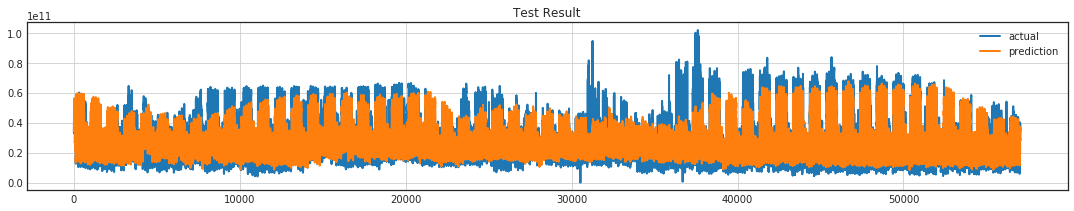

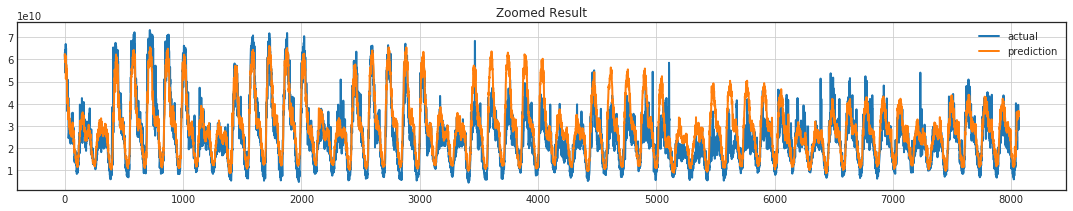

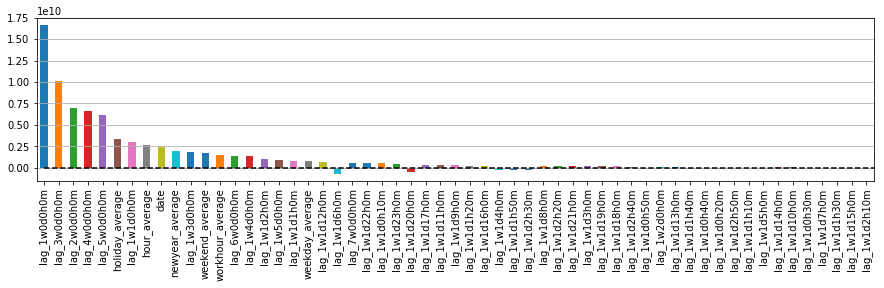

In [14]:
%%time
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
showModelStats(reg)


Train-r2: 52.05465033274195
Train-MAPE: 74.90317822358475 %
Train-MSPE: 41.87823929979137 %
Test-r2: 40.94922836347911
Test-MAPE: 77.95416340032196 %
Test-MSPE: 90.4558576109545 %
Test-r2: 63.81035926305595
Test-MAPE: 79.7577462343954 %
Test-MSPE: 93.77863805462037 %
Wall time: 3.95 s


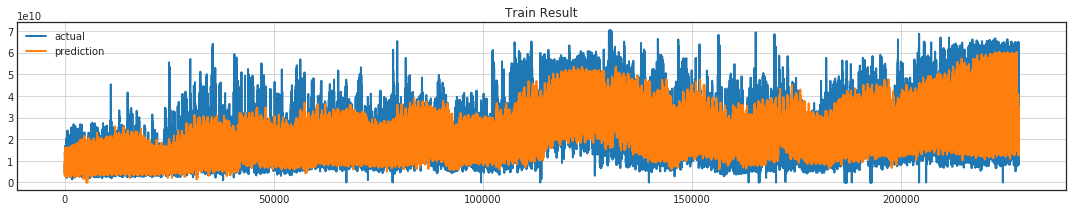

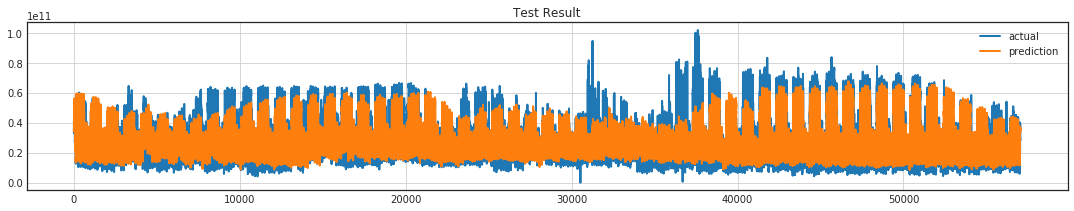

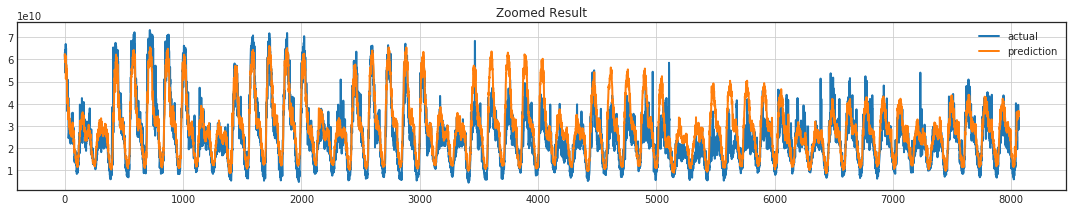

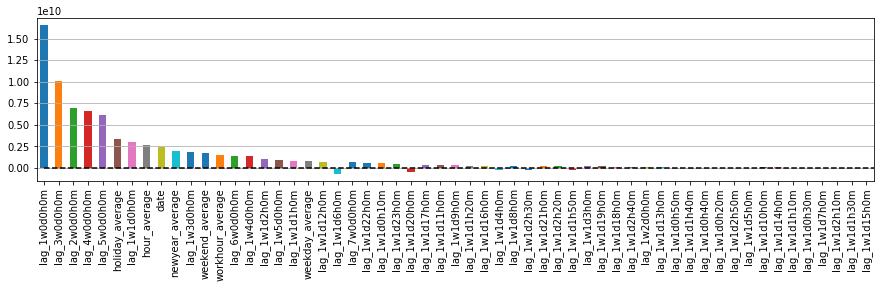

In [15]:
%%time
ridge = RidgeCV(cv=TimeSeriesSplit(n_splits=5))
ridge.fit(X_train_scaled, y_train)
showModelStats(ridge)



Train-r2: 51.94526340122301
Train-MAPE: 75.02867723162379 %
Train-MSPE: 64.30136646107252 %
Test-r2: 40.86692143149676
Test-MAPE: 77.95638039299212 %
Test-MSPE: 90.46176462276773 %
Test-r2: 63.8302596157196
Test-MAPE: 79.76180273489392 %
Test-MSPE: 93.78035047073011 %
Wall time: 10.2 s


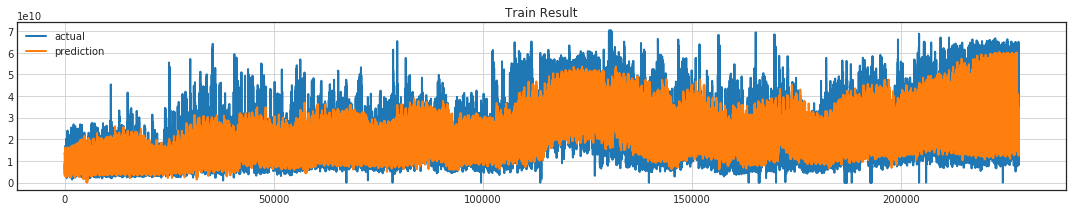

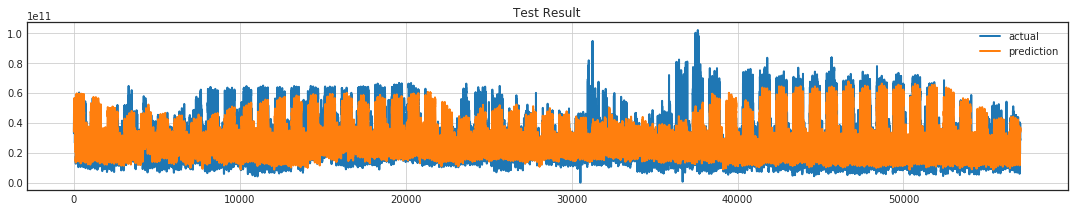

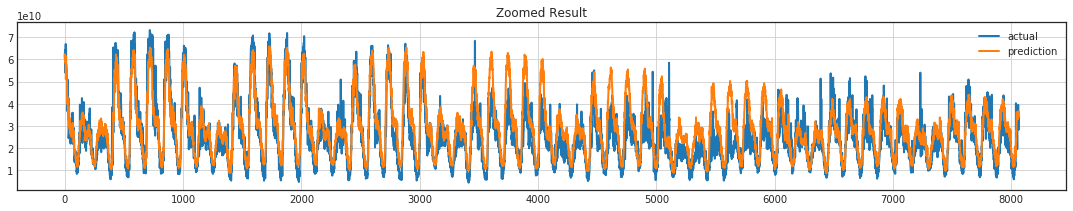

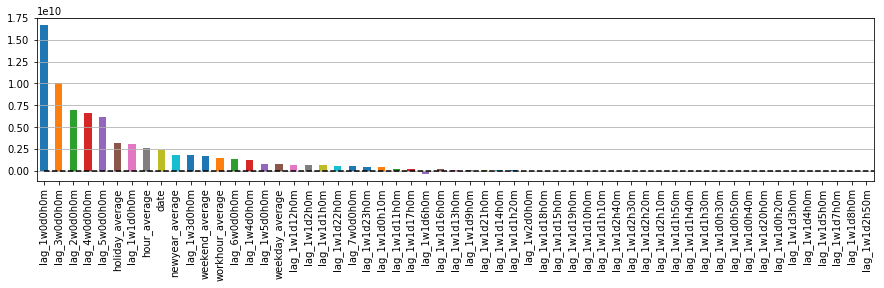

In [16]:
%%time
model = LassoCV(cv=TimeSeriesSplit(n_splits=5))
model.fit(X_train_scaled, y_train)
showModelStats(model)

### Saving Data

In [19]:
data_offset.to_csv("../data/featured_proto_traffic.csv")